In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras import backend as K
from scipy import stats
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
import os
train_file = '/content/drive/MyDrive/DataHeightWave/Ts/Onahama/OnahamaTraining.csv'
test_file = '/content/drive/MyDrive/DataHeightWave/Ts/Onahama/OnahamaTesting.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   InitJMA    414 non-null    float64
 1   24hJMA     414 non-null    float64
 2   72hJMA     414 non-null    float64
 3   120hJMA    414 non-null    float64
 4   168hJMA    414 non-null    float64
 5   InitNOAA   414 non-null    float64
 6   24hNOAA    414 non-null    float64
 7   72hNOAA    414 non-null    float64
 8   120hNOAA   414 non-null    float64
 9   168hNOAA   414 non-null    float64
 10  InitECMWF  414 non-null    float64
 11  24hECMWF   414 non-null    float64
 12  72hECMWF   414 non-null    float64
 13  120hECMWF  414 non-null    float64
 14  168hECMWF  414 non-null    float64
 15  output     414 non-null    float64
dtypes: float64(16)
memory usage: 51.9 KB
None

📊 Statistical Summary:
          InitJMA      24hJMA      72hJMA     120hJMA     168hJMA    InitNOAA  \
count  41

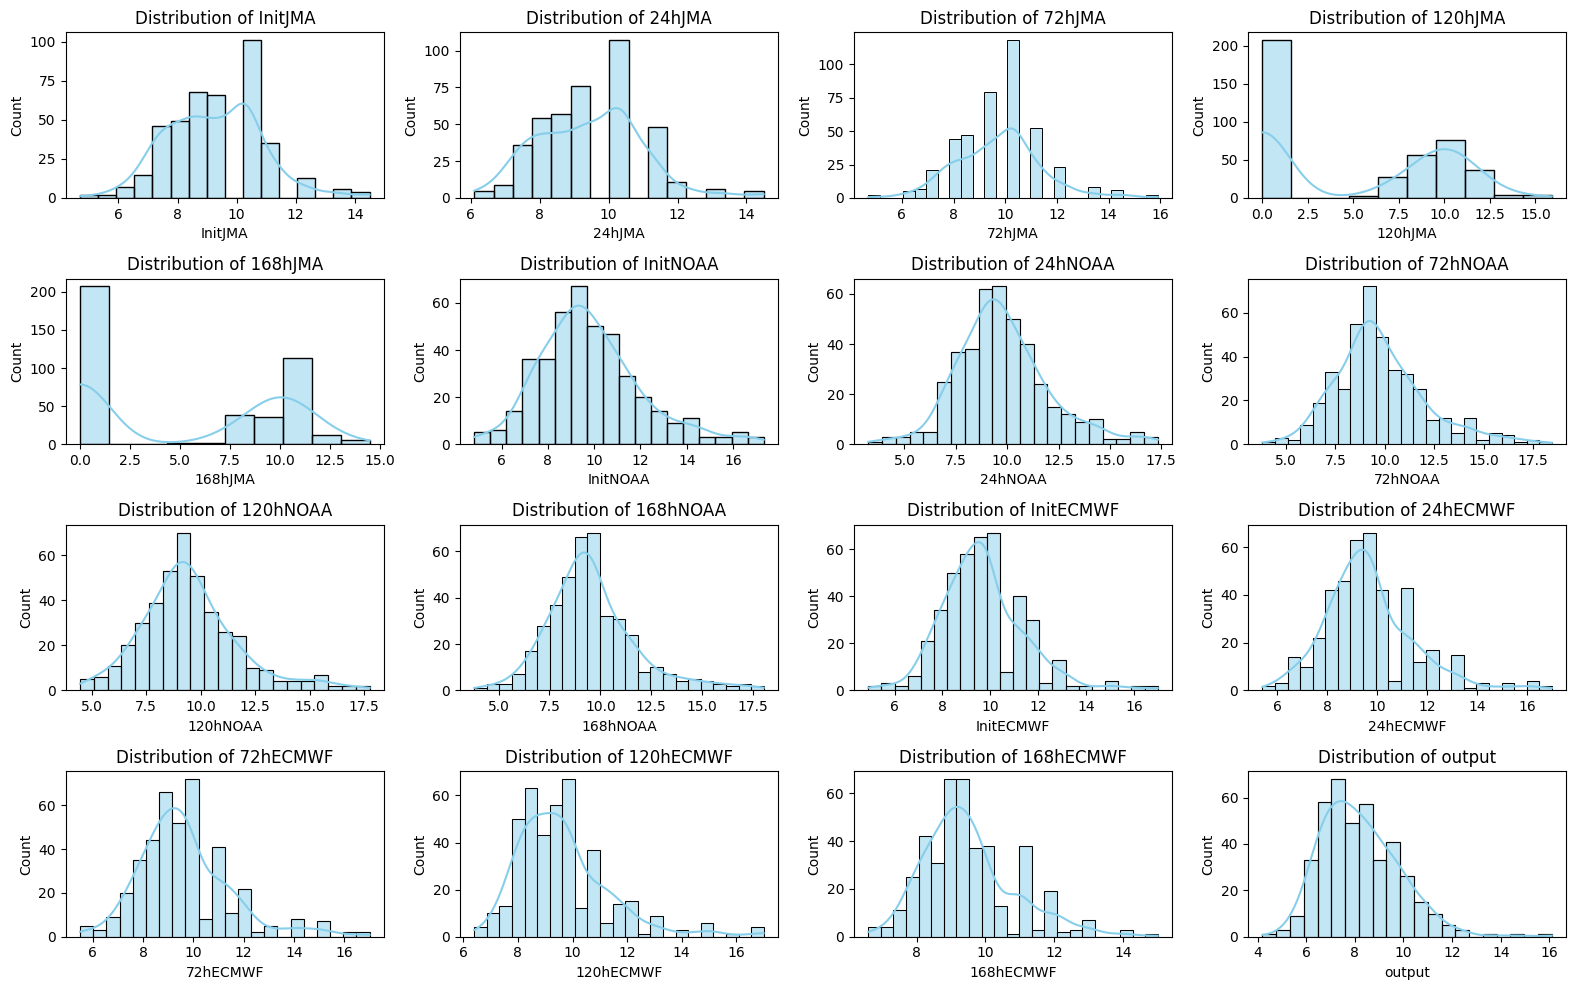

In [3]:
print("Dataset Info:")
print(train.info())
print("\n📊 Statistical Summary:")
print(train.describe())

# Plot distribution for first few features
plt.figure(figsize=(16, 10))
for i, column in enumerate(train.columns[:16]):  # ví dụ vẽ 6 cột đầu tiên
    plt.subplot(4, 4, i+1)
    sns.histplot(train[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
X_train=train.drop('output', axis=1)
y_train=train['output']
X_test=test.drop('output', axis=1)
y_test=test['output']
X_train_original = X_train.copy()
X_test_original =X_test.copy()
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_test.shape, X_train.shape
#X_train.shape

((207, 15), (414, 15))

In [5]:
#Các mô hình học máy SVR, ANN, RF
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy.stats.stats import pearsonr
#md = SVR(kernel= 'rbf', C=7, epsilon=0.001)
#md= MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', alpha=0.001, batch_size=32, learning_rate='adaptive',  max_iter=1000,  random_state=42, beta_1=0.9, beta_2=0.89)
md=RandomForestRegressor(n_estimators=50, random_state=0, oob_score=True)
# train the model on the data
md.fit(X_train, y_train)

# make predictions on the data
y_pred = md.predict(X_test)
print("MSE: %.4f" % (sqrt(mean_squared_error(y_test, y_pred))))
print("NRMSE: %.4f" % (sqrt(mean_squared_error(y_test, y_pred))/(max(y_test)-min(y_test))))
nr2=pearsonr(y_pred, y_test)
print(nr2)
#print("R2: %.4f" % sqrt(r2_score(y_test, y_pred)))

<ipython-input-5-6fd1b33fa10e>:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


MSE: 1.4852
NRMSE: 0.1248
PearsonRResult(statistic=np.float64(0.7079137363466346), pvalue=np.float64(8.632529785062808e-33))


In [6]:
#Xây dựng mô hình LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
# 4️⃣ Reshape dữ liệu để phù hợp với LSTM (batch_size, time_steps, num_features)
X_train_LSTM = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # time_steps = 1
X_test_LSTM = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 5️⃣ Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, 15)),  # LSTM layer 1
    LSTM(32, activation='relu'),  # LSTM layer 2
    Dropout(0.5),

    Dense(16, activation='relu'),  # Fully connected layer
    Dropout(0.4),
    Dense(8,activation='relu'),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6️⃣ Huấn luyện mô hình
history = model.fit(X_train_LSTM, y_train, epochs=50, batch_size=32, validation_data=(X_test_LSTM, y_test), verbose=1)

# 7️⃣ Dự báo và đánh giá mô hình
#y_pred = model.predict(X_test_LSTM)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 68.5936 - mae: 8.1387 - val_loss: 84.8539 - val_mae: 8.9811
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 66.3126 - mae: 8.0031 - val_loss: 83.6599 - val_mae: 8.9146
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67.1318 - mae: 8.0455 - val_loss: 81.9258 - val_mae: 8.8179
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 67.3715 - mae: 8.0397 - val_loss: 79.0715 - val_mae: 8.6586
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 64.2900 - mae: 7.8675 - val_loss: 73.2113 - val_mae: 8.3302
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 59.8006 - mae: 7.5339 - val_loss: 58.5658 - val_mae: 7.4472
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47.2148 - mae: 6.6419 - val_loss: 33.3118 - val_mae: 5.3912
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.8584 - mae: 5.6340 - val_loss: 27.1026 - val_mae: 4.7108
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.3

In [ ]:
#Đánh giá mô hình LSTM
ypred=model.predict(X_test_LSTM)
print("MSE: %.4f" % (sqrt(mean_squared_error(y_test, ypred))))
print("NRMSE: %.4f" % (sqrt(mean_squared_error(y_test, ypred))/(max(y_test)-min(y_test))))
correlation, _ = pearsonr(ypred.flatten(), y_test.to_numpy().flatten())
print(correlation)

In [ ]:
# 5️⃣ Xây dựng mô hình CNN
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(15, 1)),  # Conv1D layer
    Dropout(0.5),  # Dropout để tránh overfitting
    Conv1D(filters=32, kernel_size=3, activation='relu'),  # Conv1D layer thứ 2
    Dropout(0.4),
    Flatten(),  # Chuyển sang dạng 1D để đưa vào Fully Connected layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1)  # Output layer (hồi quy)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6️⃣ Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test), verbose=1)
ypred=model.predict(X_test)
print("MSE: %.4f" % (sqrt(mean_squared_error(y_test, ypred))))
print("NRMSE: %.4f" % (sqrt(mean_squared_error(y_test, ypred))/(max(y_test)-min(y_test))))
correlation, _ = pearsonr(ypred.flatten(), y_test.to_numpy().flatten())
print(correlation)